### Imports


In [1]:
import os
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from uatk_spc import Reader
import warnings

warnings.filterwarnings("ignore")

**Notes on the SPC and toolkit**:

- Aims to provide performant exploratory analysis of the data to identify properties
- Clustering among population/regions can be helpful for observing patterns in the data
- Formal statistical analysis should be avoided as the population is synthetic


### 1. Load an example region and explore data structure

As an example, load the SPC output for the Oxford-Cambridge arc region.


In [2]:
path = "../../data/output/special/2020"
region = "oxford_cambridge_arc"

Performant read from parquet and JSON with polars.


In [3]:
spc = Reader(path, region, backend="polars")

People dataframe


In [4]:
spc.people.head()

id,household,workplace,identifiers,demographics,employment,health,events,weekday_diaries,weekend_diaries
u64,u64,u64,struct[4],struct[4],struct[6],struct[7],struct[7],list[u32],list[u32]
0,0,null,"{""E02003237_0001_001"",20120504,1,2907770}","{2,64,1,2}","{""Q"",86,2112,6,null,null}","{33.83572,true,false,true,4,4,1}","{0.268,0.19832,1.9274e-13,4.4973e-13,0.219492,0.512148,0.160325}","[484, 5336, … 14013]","[483, 5337, … 14012]"
1,0,110263,"{""E02003237_0001_002"",11050508,2,2902981}","{1,63,1,2}","{""C"",30,2133,1,40137.558594,22.053602}","{27.844835,false,false,false,3,3,3}","{0.268,0.33768,1.9678e-12,8.4334e-13,0.611176,0.261932,0.160325}","[235, 816, … 16212]","[234, 815, … 16211]"
2,0,94582,"{""E02003237_0001_003"",18220910,2,2905963}","{2,16,1,7}","{""G"",47,7111,2,6708.0,6.45}","{23.245779,false,false,false,0,2,3}","{0.257,0.09509,0.766659,1.788871,0.016998,0.039662,0.131175}","[400, 1321, … 16148]","[399, 1320, … 16147]"
3,1,null,"{""E02003237_0002_001"",18050513,1,2910157}","{1,86,1,7}","{""C"",25,8125,6,null,null}","{26.839546,true,false,true,6,2,4}","{0.09,0.0567,2.9846e-31,1.2791e-31,0.000881,0.000377,0.10494}","[9656, 10928, 11338]","[9655, 10929, 11339]"
4,2,null,"{""E02003237_0003_001"",12290907,2,2903621}","{2,43,1,3}","{""Q"",86,2231,7,null,null}","{16.375051,false,false,false,null,2,null}","{0.255,0.1887,0.002312,0.005394,1.150078,2.683516,0.15741}","[2272, 3206, … 16310]","[2273, 3207, … 16311]"


In [5]:
spc.summary("people")

Shape: (3811684, 10)


{'id': UInt64,
 'household': UInt64,
 'workplace': UInt64,
 'identifiers': Struct({'orig_pid': String, 'id_tus_hh': Int64, 'id_tus_p': Int64, 'pid_hs': Int64}),
 'demographics': Struct({'sex': Int32, 'age_years': UInt32, 'ethnicity': Int32, 'nssec8': Int32}),
 'employment': Struct({'sic1d2007': String, 'sic2d2007': UInt64, 'soc2010': UInt64, 'pwkstat': Int32, 'salary_yearly': Float32, 'salary_hourly': Float32}),
 'health': Struct({'bmi': Float32, 'has_cardiovascular_disease': Boolean, 'has_diabetes': Boolean, 'has_high_blood_pressure': Boolean, 'number_medications': UInt64, 'self_assessed_health': Int32, 'life_satisfaction': Int32}),
 'events': Struct({'sport': Float32, 'rugby': Float32, 'concert_m': Float32, 'concert_f': Float32, 'concert_ms': Float32, 'concert_fs': Float32, 'museum': Float32}),
 'weekday_diaries': List(UInt32),
 'weekend_diaries': List(UInt32)}

View unnested forms of: "health", "employment", "events"


In [6]:
col = "health"
print(spc.people.select(col).unnest(col).head())

shape: (5, 7)
┌───────────┬──────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┐
│ bmi       ┆ has_cardiova ┆ has_diabetes ┆ has_high_blo ┆ number_medi ┆ self_assess ┆ life_satisf │
│ ---       ┆ scular_disea ┆ ---          ┆ od_pressure  ┆ cations     ┆ ed_health   ┆ action      │
│ f32       ┆ se           ┆ bool         ┆ ---          ┆ ---         ┆ ---         ┆ ---         │
│           ┆ ---          ┆              ┆ bool         ┆ u64         ┆ i32         ┆ i32         │
│           ┆ bool         ┆              ┆              ┆             ┆             ┆             │
╞═══════════╪══════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╡
│ 33.83572  ┆ true         ┆ false        ┆ true         ┆ 4           ┆ 4           ┆ 1           │
│ 27.844835 ┆ false        ┆ false        ┆ false        ┆ 3           ┆ 3           ┆ 3           │
│ 23.245779 ┆ false        ┆ false        ┆ false        ┆ 0           ┆ 2   

In [7]:
col = "employment"
print(spc.people.select(col).unnest(col).head())

shape: (5, 6)
┌───────────┬───────────┬─────────┬─────────┬───────────────┬───────────────┐
│ sic1d2007 ┆ sic2d2007 ┆ soc2010 ┆ pwkstat ┆ salary_yearly ┆ salary_hourly │
│ ---       ┆ ---       ┆ ---     ┆ ---     ┆ ---           ┆ ---           │
│ str       ┆ u64       ┆ u64     ┆ i32     ┆ f32           ┆ f32           │
╞═══════════╪═══════════╪═════════╪═════════╪═══════════════╪═══════════════╡
│ Q         ┆ 86        ┆ 2112    ┆ 6       ┆ null          ┆ null          │
│ C         ┆ 30        ┆ 2133    ┆ 1       ┆ 40137.558594  ┆ 22.053602     │
│ G         ┆ 47        ┆ 7111    ┆ 2       ┆ 6708.0        ┆ 6.45          │
│ C         ┆ 25        ┆ 8125    ┆ 6       ┆ null          ┆ null          │
│ Q         ┆ 86        ┆ 2231    ┆ 7       ┆ null          ┆ null          │
└───────────┴───────────┴─────────┴─────────┴───────────────┴───────────────┘


In [8]:
col = "health"
print(spc.people.select(col).unnest(col))

shape: (3_811_684, 7)
┌───────────┬──────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┐
│ bmi       ┆ has_cardiova ┆ has_diabetes ┆ has_high_blo ┆ number_medi ┆ self_assess ┆ life_satisf │
│ ---       ┆ scular_disea ┆ ---          ┆ od_pressure  ┆ cations     ┆ ed_health   ┆ action      │
│ f32       ┆ se           ┆ bool         ┆ ---          ┆ ---         ┆ ---         ┆ ---         │
│           ┆ ---          ┆              ┆ bool         ┆ u64         ┆ i32         ┆ i32         │
│           ┆ bool         ┆              ┆              ┆             ┆             ┆             │
╞═══════════╪══════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╡
│ 33.83572  ┆ true         ┆ false        ┆ true         ┆ 4           ┆ 4           ┆ 1           │
│ 27.844835 ┆ false        ┆ false        ┆ false        ┆ 3           ┆ 3           ┆ 3           │
│ 23.245779 ┆ false        ┆ false        ┆ false        ┆ 0         

Households dataframe


In [9]:
spc.households.head()

id,msoa11cd,oa11cd,members,details
u64,str,str,list[u64],struct[8]
0,"""E02003237""","""E00079294""","[0, 1, 2]","{""E02003237_0001"",2,2,null,6,true,2,1}"
1,"""E02003237""","""E00079304""",[3],"{""E02003237_0002"",7,1,null,5,true,1,0}"
2,"""E02003237""","""E00079300""",[4],"{""E02003237_0003"",3,3,null,5,true,2,1}"
3,"""E02003237""","""E00079298""","[5, 6, … 8]","{""E02003237_0004"",1,1,null,6,true,2,2}"
4,"""E02003237""","""E00079032""","[9, 10]","{""E02003237_0005"",1,2,null,6,true,2,2}"


In [10]:
spc.summary("households")

Shape: (1540412, 5)


{'id': UInt64,
 'msoa11cd': String,
 'oa11cd': String,
 'members': List(UInt64),
 'details': Struct({'hid': String, 'nssec8': Int32, 'accommodation_type': Int32, 'communal_type': Int32, 'num_rooms': UInt64, 'central_heat': Boolean, 'tenure': Int32, 'num_cars': UInt64})}

In [11]:
col = "details"
spc.households.unnest("details").head()

id,msoa11cd,oa11cd,members,hid,nssec8,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars
u64,str,str,list[u64],str,i32,i32,i32,u64,bool,i32,u64
0,"""E02003237""","""E00079294""","[0, 1, 2]","""E02003237_0001…",2,2,null,6,true,2,1
1,"""E02003237""","""E00079304""",[3],"""E02003237_0002…",7,1,null,5,true,1,0
2,"""E02003237""","""E00079300""",[4],"""E02003237_0003…",3,3,null,5,true,2,1
3,"""E02003237""","""E00079298""","[5, 6, … 8]","""E02003237_0004…",1,1,null,6,true,2,2
4,"""E02003237""","""E00079032""","[9, 10]","""E02003237_0005…",1,2,null,6,true,2,2


Show venues


In [12]:
spc.venues_per_activity.head()

id,activity,location,urn
u64,str,struct[2],str
0,"""0""","{-0.203788,51.981995}",null
1,"""0""","{-0.522467,51.903172}",null
2,"""0""","{-1.28335,51.669636}",null
3,"""0""","{-1.279668,51.672077}",null
4,"""0""","{-1.309456,51.66703}",null


Show time use diaries


In [13]:
spc.time_use_diaries.head()

uid,weekday,day_type,month,pworkhome,phomeother,pwork,pschool,pshop,pservices,pleisure,pescort,ptransport,phome_total,pnothome_total,punknown_total,pmwalk,pmcycle,pmprivate,pmpublic,pmunknown,sex,age35g,nssec8,pwkstat
str,bool,i32,u32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,u32,i32,i32
"""11011202_1_0""",false,3,12,0.0,0.82639,0.0,0.0,0.0625,0.0,0.09028,0.0,0.02083,0.82639,0.17361,0.0,0.0,0.0,1.0,0.0,0.0,2,13,4,1
"""11011202_1_1""",true,3,12,0.0,0.79166,0.0,0.0,0.04167,0.0,0.125,0.0,0.04167,0.79166,0.20834,0.0,0.0,0.0,1.0,0.0,0.0,2,13,4,1
"""11011202_4_1""",true,2,12,0.0,0.61111,0.0,0.27778,0.0,0.0,0.0,0.0,0.11111,0.61111,0.38889,0.0,0.0625,0.0,0.0625,0.875,0.0625,1,6,null,0
"""11011202_4_0""",false,3,12,0.0,0.80556,0.0,0.01389,0.14583,0.0,0.03472,0.0,0.0,0.80556,0.19444,0.0,0.0,0.0,0.0,0.0,0.0,1,6,null,0
"""11011203_1_0""",false,3,12,0.0,0.90972,0.0,0.0,0.0,0.0,0.04167,0.0,0.04861,0.90972,0.09028,0.0,0.41667,0.0,0.91667,0.0,0.08333,1,19,1,6


In [14]:
spc.summary("time_use_diaries")

Shape: (16406, 25)


{'uid': String,
 'weekday': Boolean,
 'day_type': Int32,
 'month': UInt32,
 'pworkhome': Float32,
 'phomeother': Float32,
 'pwork': Float32,
 'pschool': Float32,
 'pshop': Float32,
 'pservices': Float32,
 'pleisure': Float32,
 'pescort': Float32,
 'ptransport': Float32,
 'phome_total': Float32,
 'pnothome_total': Float32,
 'punknown_total': Float32,
 'pmwalk': Float32,
 'pmcycle': Float32,
 'pmprivate': Float32,
 'pmpublic': Float32,
 'pmunknown': Float32,
 'sex': Int32,
 'age35g': UInt32,
 'nssec8': Int32,
 'pwkstat': Int32}

Show info per MSOA field (expand an example MSOA)


In [15]:
spc.info_per_msoa["E02003599"].keys()

dict_keys(['shape', 'population', 'buildings', 'flows_per_activity'])

In [16]:
msoas = list(spc.info_per_msoa.keys())
spc.info_per_msoa[msoas[0]]["flows_per_activity"]

[{'activity': 0,
  'flows': [{'venue_id': 41, 'weight': 0.07343511684672088},
   {'venue_id': 168, 'weight': 0.07365690202248147},
   {'venue_id': 92, 'weight': 0.08001937703290209},
   {'venue_id': 218, 'weight': 0.08111719039048813},
   {'venue_id': 101, 'weight': 0.08620092391179641},
   {'venue_id': 190, 'weight': 0.0880263872161068},
   {'venue_id': 245, 'weight': 0.10403438920960656},
   {'venue_id': 94, 'weight': 0.12236275264776975},
   {'venue_id': 42, 'weight': 0.13186451610799213},
   {'venue_id': 117, 'weight': 0.15928244461413568}]},
 {'activity': 1,
  'flows': [{'venue_id': 14, 'weight': 0.16306653489475026},
   {'venue_id': 9, 'weight': 0.187514995144368},
   {'venue_id': 12, 'weight': 0.20540218163013066},
   {'venue_id': 11, 'weight': 0.21877787131605916},
   {'venue_id': 8, 'weight': 0.2252384170146919}]},
 {'activity': 2,
  'flows': [{'venue_id': 1, 'weight': 0.14419544545642513},
   {'venue_id': 223, 'weight': 0.18187880118334185},
   {'venue_id': 5, 'weight': 0.183

### Plot venues in region


In [17]:
df = spc.venues_per_activity.unnest("location").filter(pl.col("activity") != "4")
print(df)
px.set_mapbox_access_token(os.getenv("MAPBOX_KEY"))
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", color="activity")
fig.show()

shape: (1_044, 5)
┌─────┬──────────┬───────────┬───────────┬────────┐
│ id  ┆ activity ┆ longitude ┆ latitude  ┆ urn    │
│ --- ┆ ---      ┆ ---       ┆ ---       ┆ ---    │
│ u64 ┆ str      ┆ f32       ┆ f32       ┆ str    │
╞═════╪══════════╪═══════════╪═══════════╪════════╡
│ 0   ┆ 0        ┆ -0.203788 ┆ 51.981995 ┆ null   │
│ 1   ┆ 0        ┆ -0.522467 ┆ 51.903172 ┆ null   │
│ 2   ┆ 0        ┆ -1.28335  ┆ 51.669636 ┆ null   │
│ 3   ┆ 0        ┆ -1.279668 ┆ 51.672077 ┆ null   │
│ 4   ┆ 0        ┆ -1.309456 ┆ 51.66703  ┆ null   │
│ …   ┆ …        ┆ …         ┆ …         ┆ …      │
│ 243 ┆ 2        ┆ -0.446952 ┆ 51.537365 ┆ 102449 │
│ 244 ┆ 2        ┆ -0.588381 ┆ 51.520817 ┆ 146820 │
│ 245 ┆ 2        ┆ -0.917678 ┆ 51.454231 ┆ 110062 │
│ 246 ┆ 2        ┆ -1.058186 ┆ 51.455093 ┆ 110063 │
│ 247 ┆ 2        ┆ -0.290272 ┆ 52.13784  ┆ 109669 │
└─────┴──────────┴───────────┴───────────┴────────┘


### 2. Explore demographic and health data


<Axes: ylabel='Count'>

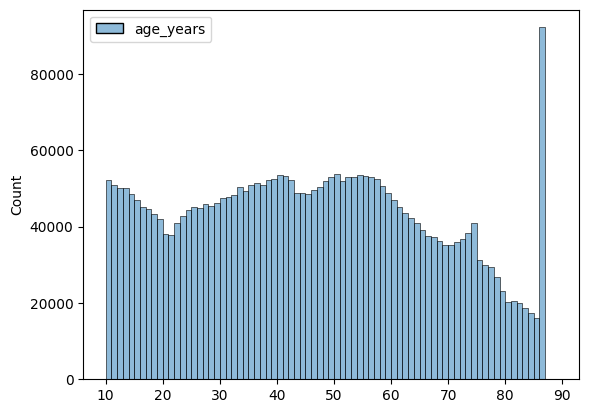

In [18]:
# Plot Age
sns.histplot(
    spc.people.unnest("demographics").select("age_years").to_pandas(),
    bins=np.arange(10, 90),
)

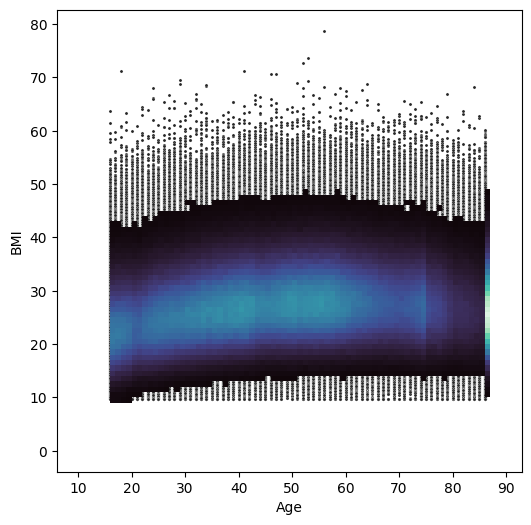

In [19]:
# Plot 2D hist of Age and BMI
age_bmi = (
    spc.people.unnest("demographics")
    .unnest("health")
    .select(["age_years", "bmi"])
    .filter(pl.col("bmi").is_not_null())
    .to_numpy()
)

# Draw a combination of histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
x, y = age_bmi[:, 0], age_bmi[:, 1]
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(
    x=x, y=y, bins=[np.arange(10, 90), np.arange(0, 60)], pthresh=0.01, cmap="mako"
)
plt.gca().set(xlabel="Age", ylabel="BMI")
plt.show()

#### 2.2 Combine with weekday diaries

**Question: Are weekday activities related to health features?**

Pick some features to explore, merge and aggregate. See [data schema](https://github.com/alan-turing-institute/uatk-spc/blob/main/synthpop.proto) for more details.


In [20]:
# Merge and pick first diary entry as an example, many possible options for aggregating!
features = {
    # "health": ["bmi"],
    "health": [
        "bmi",
        "has_cardiovascular_disease",
        "has_diabetes",
        "has_high_blood_pressure",
        "self_assessed_health",
        "life_satisfaction",
    ],
    "demographics": ["age_years", "sex", "nssec8"],
    "employment": ["pwkstat", "salary_yearly"],
}
merged = spc.merge_people_and_time_use_diaries(features, "weekday_diaries")

# Pick a subset of activities to explore
activities = ["pmwalk", "pmcycle", "pmprivate", "pmpublic", "pmunknown", "pleisure"]

# First diary per person across all diaries
merged_agg = (
    merged.select(
        ["id"]
        + activities
        + features["health"]
        + features["demographics"]
        + features["employment"]
    ).groupby(["id"], maintain_order=True)
    .first()
)

In [21]:
merged_agg.head()

id,pmwalk,pmcycle,pmprivate,pmpublic,pmunknown,pleisure,bmi,has_cardiovascular_disease,has_diabetes,has_high_blood_pressure,self_assessed_health,life_satisfaction,age_years,sex,nssec8,pwkstat,salary_yearly
u64,f32,f32,f32,f32,f32,f32,f32,bool,bool,bool,i32,i32,u32,i32,i32,i32,f32
0,0.5,0.0,1.0,0.0,0.0,0.09722,33.83572,true,false,true,4,1,64,2,2,6,null
1,0.0,0.0,1.0,0.0,0.0,0.03472,27.844835,false,false,false,3,3,63,1,2,1,40137.558594
2,0.0,0.0,0.66667,0.0,0.33333,0.1875,23.245779,false,false,false,2,3,16,2,7,2,6708.0
3,0.0,0.0,1.0,0.0,0.0,0.0,26.839546,true,false,true,2,4,86,1,7,6,null
4,0.15,0.0,0.6,0.0,0.4,0.02778,16.375051,false,false,false,2,null,43,2,3,7,null


#### Plotting activity distributions


In [22]:
print(activities)

['pmwalk', 'pmcycle', 'pmprivate', 'pmpublic', 'pmunknown', 'pleisure']


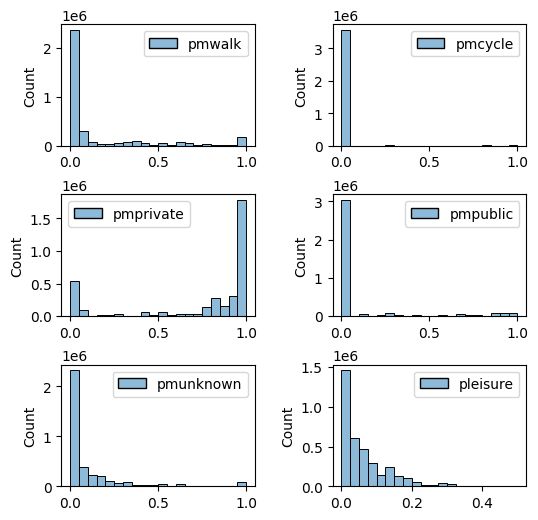

In [23]:
nrows, ncols = 3, 2
fig, axs = plt.subplots(nrows, ncols)
fig.set_size_inches(6, 6)
for idx, activity in enumerate(activities):
    row, col = idx // ncols, idx % ncols
    ax = axs[row, col]
    sns.histplot(merged_agg.select(activity).to_pandas(), bins=20, ax=ax)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

Perform a simple clustering of the six activity features with K-means.


In [24]:
nclusters = 6
data = merged_agg.select(activities).to_numpy()
labels = KMeans(nclusters, random_state=0).fit_predict(data)

Plot the resultant means per feature of the clusters.


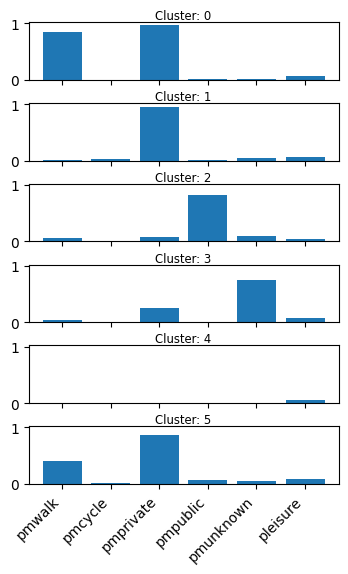

In [25]:
nrows, ncols = nclusters, 1
fig, axs = plt.subplots(nrows, ncols, squeeze=False, sharey=True)
fig.set_size_inches(4, 6)
for cluster_idx in np.arange(0, nclusters):
    ax = axs[cluster_idx, 0]
    idxs = np.where(cluster_idx == labels)[0]
    ax.set_title(
        f"Cluster: {cluster_idx}", fontdict={"size": "small"}, ha="center", pad=-0.1
    )
    ax.bar(
        np.arange(len(activities)),
        merged_agg.select(activities).to_pandas().iloc[idxs, :].mean(axis=0).to_numpy(),
    )
    ax.set_xticks(np.arange(len(activities)))
    if cluster_idx == nclusters - 1:
        ax.set_xticklabels(activities, rotation=45, ha="right")
    else:
        ax.set_xticklabels([])
plt.subplots_adjust(hspace=0.4)
plt.show()

Plot the distribution of age and bmi for each cluster.


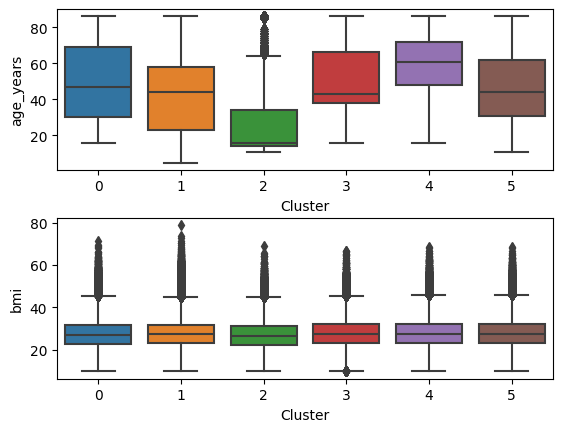

In [26]:
fig, axs = plt.subplots(2, 1, squeeze=False)
for idx, y in enumerate(["age_years", "bmi"]):
    ax = axs[idx, 0]
    sns.boxplot(
        merged_agg.with_columns(
            Cluster=pl.lit(labels),
        ).to_pandas(),
        x="Cluster",
        y=y,
        ax=ax,
    )
# fig.set_size_inches(5, 6)
fig.subplots_adjust(hspace=0.3)
plt.show()

Plot the break down for age with additionally life satisfaction included.


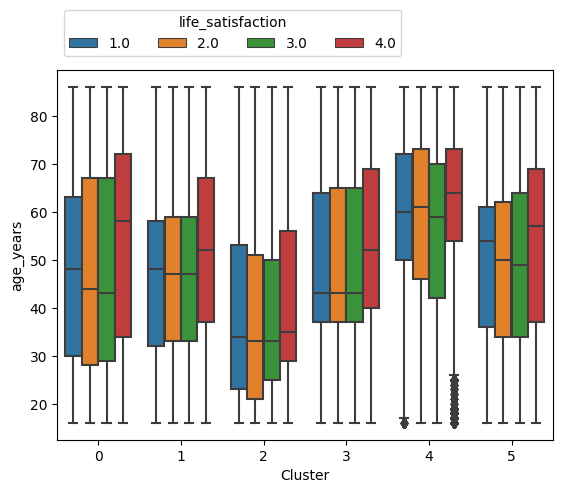

In [27]:
ax = sns.boxplot(
    merged_agg.with_columns(
        Cluster=pl.lit(labels),
    ).to_pandas(),
    x="Cluster",
    y="age_years",
    hue="life_satisfaction",
)
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1.02), ncols=5)

### 3. Comparison of two regions

Multiple readers can be created to allow comparison of different region's populations.


In [28]:
greater_london = Reader(
    "../../data/output/England/2020",
    "greater-london",
)
northwest_transpennine = Reader(
    "../../data/output/special/2020", "northwest_transpennine"
)

In [29]:
def combine(left: pl.DataFrame, right: pl.DataFrame, label_left: str, label_right: str):
    """Construct combined table with people and households and two regions"""
    combined = pl.concat(
        [
            left.with_columns(region=pl.lit(label_left)),
            right.with_columns(region=pl.lit(label_right)),
        ]
    )
    return (
        combined.unnest("demographics")
        .unnest("health")
        .select(pl.all().exclude("nssec8"))
        .unnest("details")
        .unnest("employment")
    )

Make combined dataframe


In [30]:
left_region, right_region = "Greater London", "Northwest Transpennine"
combined = combine(
    greater_london.merge_people_and_households(),
    northwest_transpennine.merge_people_and_households(),
    left_region,
    right_region,
)

In [31]:
print(f"Combined regions has a population of {combined.shape[0]:,.0f} people")

Combined regions has a population of 15,608,611 people


Examine columns


In [32]:
dict(zip(combined.columns, combined.dtypes))

{'id': UInt64,
 'household': UInt64,
 'workplace': UInt64,
 'orig_pid': String,
 'id_tus_hh': Int64,
 'id_tus_p': Int64,
 'pid_hs': Int64,
 'sex': Int32,
 'age_years': UInt32,
 'ethnicity': Int32,
 'sic1d2007': String,
 'sic2d2007': UInt64,
 'soc2010': UInt64,
 'pwkstat': Int32,
 'salary_yearly': Float32,
 'salary_hourly': Float32,
 'bmi': Float32,
 'has_cardiovascular_disease': Boolean,
 'has_diabetes': Boolean,
 'has_high_blood_pressure': Boolean,
 'number_medications': UInt64,
 'self_assessed_health': Int32,
 'life_satisfaction': Int32,
 'events': Struct({'sport': Float32, 'rugby': Float32, 'concert_m': Float32, 'concert_f': Float32, 'concert_ms': Float32, 'concert_fs': Float32, 'museum': Float32}),
 'weekday_diaries': List(UInt32),
 'weekend_diaries': List(UInt32),
 'msoa11cd': String,
 'oa11cd': String,
 'members': List(UInt64),
 'hid': String,
 'nssec8': Int32,
 'accommodation_type': Int32,
 'communal_type': Int32,
 'num_rooms': UInt64,
 'central_heat': Boolean,
 'tenure': Int32,

**Question: how do salaries in the two regions compare? What features are associated?**


Histogram of yearly salaries for two regions


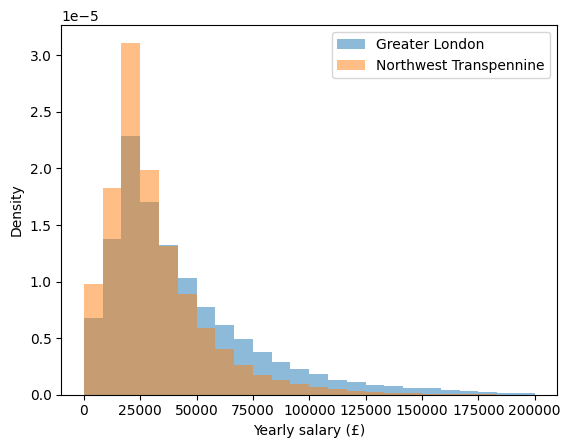

In [33]:
fig, ax = plt.subplots(1, 1)
bins = np.linspace(0, 200000, 25, endpoint=True)
ax.hist(
    combined.filter(pl.col("region") == left_region).select("salary_yearly"),
    alpha=0.5,
    bins=bins,
    label=left_region,
    density=True,
)
ax.hist(
    combined.filter(pl.col("region") == right_region).select("salary_yearly"),
    alpha=0.5,
    bins=bins,
    label=right_region,
    density=True,
)
ax.legend()
# ax.set(ylim=(0, 0.0001))
ax.set(xlabel="Yearly salary (£)", ylabel="Density")
plt.show()

A boxplot split by region and tenure of log scaled yearly salary.


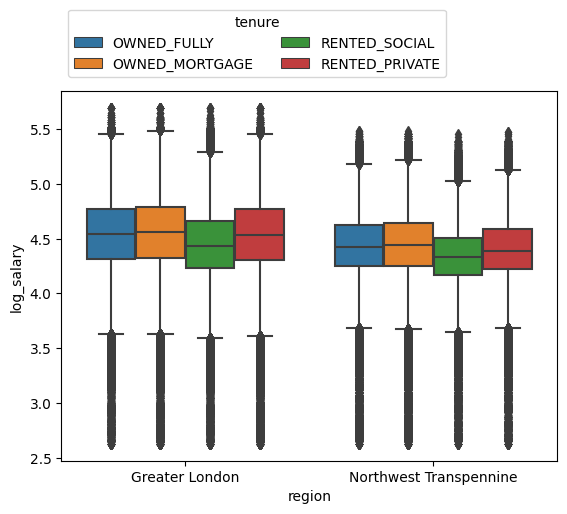

In [34]:
ax = sns.boxplot(
    combined.with_columns(
        log_salary=np.log10(pl.col("salary_yearly")),
        tenure=pl.col("tenure").apply(
            lambda x: {
                1: "OWNED_FULLY",
                2: "OWNED_MORTGAGE",
                4: "RENTED_SOCIAL",
                5: "RENTED_PRIVATE",
            }[x]
        ),
    ).to_pandas(),
    y="log_salary",
    x="region",
    hue="tenure",
)
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1.02), ncols=2)